<a href="https://colab.research.google.com/github/fedraameneiro/DataScientistFinalProject/blob/main/Desafio_FeactureSelection_FedraAmeneiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto diabetes



Realizamos el análisis de 100000 muestras de pacientes hasta los 80 años y analizamos la probabilidad de sufrir diabetes según las variables de hipertensión, problemas cardiovasculares, histórico fumando, índice corporal, nivel de HbA1c y glucosa en sangre.
Analizaremos primeramente las variables únicas, luego las variables multiples y finalmente haremos uso de un algoritmo de Machine Learning para predecir la probabilidad de sufrir diabetes según estas variables.
Necesitamos saber cuál es o son las variables que más nos afectan a la hora de sufrir esta enfermedad.


**Glosario**

*   gender                Género del paciente. Hombre o mujer.
*   age                   Edad del paciente en el momento de la muestra.
*   hypertension          Si el paciente presenta hipertensión como patología es 1.
*   heart_disease         Si el paciente presenta patologías cardiovasculares, es 1.
*   smoking_history       Antecedentes en la relación con el tabaco.
*   bmi                   Indice de masa corporal.
*   HbA1c_level           Niveles de HbA1c.
*   blood_glucose_level   Niveles de glucosa en sangre.
*   diabetes              Si el diagnóstico final es con diabetes es 1.













In [ ]:
#librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import plotly as pl
import plotly.express as px


In [ ]:
#obtener el archivo csv de drive

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/18ymyIaVZ8FK7WhyGltLrJbfx2nyvzjtK/view?usp=drive_link'

# to get the id part of the file
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('diabetes.csv')

In [ ]:
df=pd.read_csv('diabetes.csv', sep=';')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80,0,1,never,"25,19","6,6",140,0
1,Female,54,0,0,No Info,"27,32","6,6",80,0
2,Male,28,0,0,never,"27,32","5,7",158,0
3,Female,36,0,0,current,"23,45",5,155,0
4,Male,76,1,1,current,"20,14","4,8",155,0


Tenemos 4 variables categoricas y la variable objetivo. Y 3 variables numericas.

In [ ]:
df.dtypes

gender                 object
age                     int64
hypertension            int64
heart_disease           int64
smoking_history        object
bmi                    object
HbA1c_level            object
blood_glucose_level     int64
diabetes                int64
dtype: object

In [ ]:
df.count()

gender                 100000
age                    100000
hypertension           100000
heart_disease          100000
smoking_history        100000
bmi                    100000
HbA1c_level            100000
blood_glucose_level    100000
diabetes               100000
dtype: int64

Antes de nada voy a chequear aquellas  variables numericas que aparecen como objetos y los voy a modificar. bmi y HbA1c_level deberían ser enteros. Les voy a cambiar la coma por un punto.

In [ ]:
df.bmi=df.bmi.str.replace(',','.')
df.HbA1c_level=df.HbA1c_level.str.replace(',','.')
df.bmi=df["bmi"].astype(float)
df.HbA1c_level=df["HbA1c_level"].astype(float)
df.dtypes

gender                  object
age                      int64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,41.885790,22.517039,0.00,24.00,43.00,60.00,80.00
hypertension,100000.0,0.074850,0.263150,0.00,0.00,0.00,0.00,1.00
heart_disease,100000.0,0.039420,0.194593,0.00,0.00,0.00,0.00,1.00
bmi,100000.0,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,5.527507,1.070672,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,100000.0,138.058060,40.708136,80.00,100.00,140.00,159.00,300.00
diabetes,100000.0,0.085000,0.278883,0.00,0.00,0.00,0.00,1.00


In [ ]:
df_diabetes=df[df.diabetes==1]
df_nodiabetes=df[df.diabetes==0]
df_diabetes.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
6,Female,44,0,0,never,19.31,6.5,200,1
26,Male,67,0,1,not current,27.32,6.5,200,1
38,Male,50,1,0,current,27.32,5.7,260,1
40,Male,73,0,0,former,25.91,9.0,160,1
53,Female,53,0,0,former,27.32,7.0,159,1


#Ingeniería de factores
Feacture creation y Feacture Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  int64  
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 6.9+ MB


In [ ]:
df.age.value_counts()

80    5621
2     1708
51    1619
47    1574
48    1568
      ... 
77     730
75     721
78     682
79     621
0      420
Name: age, Length: 81, dtype: int64

In [ ]:
df.isnull().sum()/df.shape[0]

gender                 0.0
age                    0.0
hypertension           0.0
heart_disease          0.0
smoking_history        0.0
bmi                    0.0
HbA1c_level            0.0
blood_glucose_level    0.0
diabetes               0.0
dtype: float64

No hay nulos

In [ ]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

No hay NaN

Heatmap entre todas las variables numericas medidas

<ipython-input-13-24adb5da014a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df.corr(),dtype = bool))
<ipython-input-13-24adb5da014a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),mask = mask, fmt = ".2f",annot=True,lw=1,cmap="Blues")


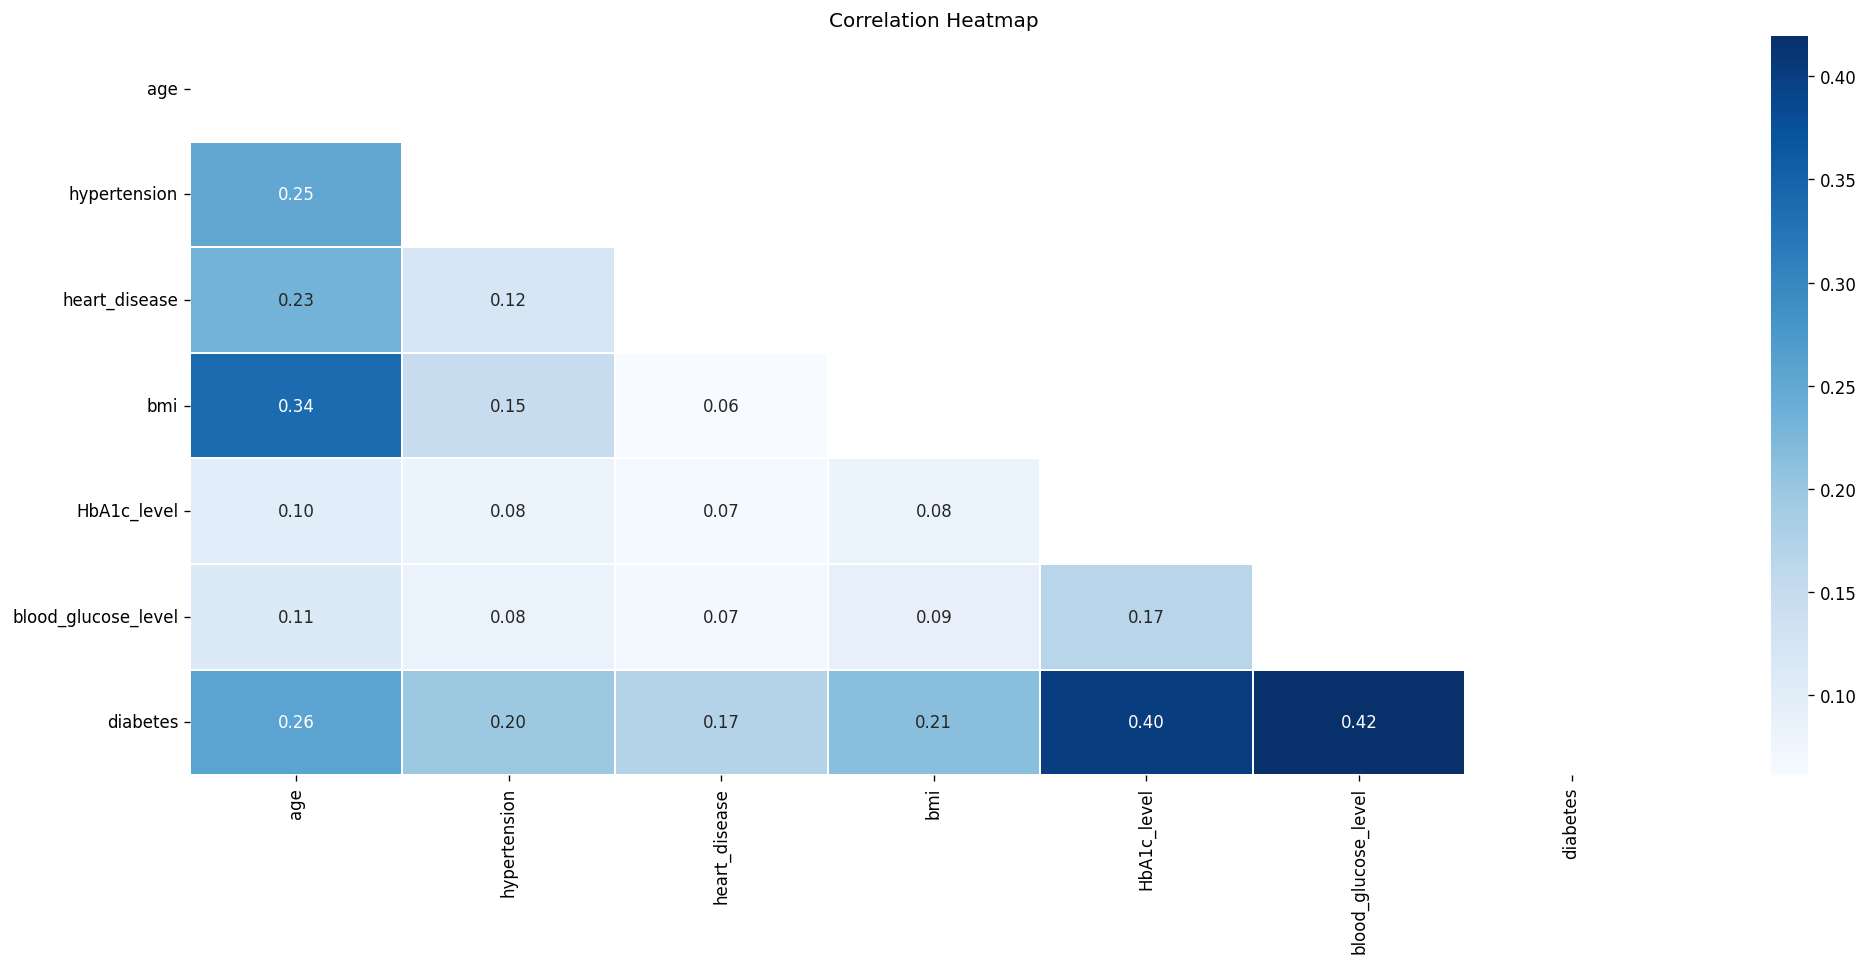

In [ ]:
plt.figure(dpi = 120,figsize= (20,8))
mask = np.triu(np.ones_like(df.corr(),dtype = bool))
sns.heatmap(df.corr(),mask = mask, fmt = ".2f",annot=True,lw=1,cmap="Blues")
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show()

Relación entre nuestras variables categoricas

In [ ]:
pd.crosstab(df.gender, df.smoking_history)

smoking_history,No Info,current,ever,former,never,not current
gender,,,,,,
Female,19700,5058,2238,4774,22869,3913
Male,16110,4228,1765,4578,12223,2526
Other,6,0,1,0,3,8


Eliminamos aquellas muestras con genero other.

In [ ]:
df['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [ ]:
df=df[df.gender!='Other']

In [ ]:
pd.crosstab(df.gender, df.smoking_history)

smoking_history,No Info,current,ever,former,never,not current
gender,,,,,,
Female,19700,5058,2238,4774,22869,3913
Male,16110,4228,1765,4578,12223,2526


#Analisis exploratorio de los datos. EDA

#Analisis Univariado


Vemos la cantidad de diabéticos de nuestro estudio, son relativamente pocos en relación al estudio total, pero suficientes. 8500 de 100000 pacientes, 8.5%.

In [ ]:
#cantidad total de registros
len(df)

99982

In [ ]:
#cantidad de diabeticos en total
df.diabetes.sum()

8500

Revisamos la relación entre ser diabetico y no en nuestras muestras

In [ ]:
numero_de_diabeticos = len(df_diabetes)
numero_de_no_diabeticos= len(df_nodiabetes)

Text(0.5, 1.0, 'Distribucion de barrios')

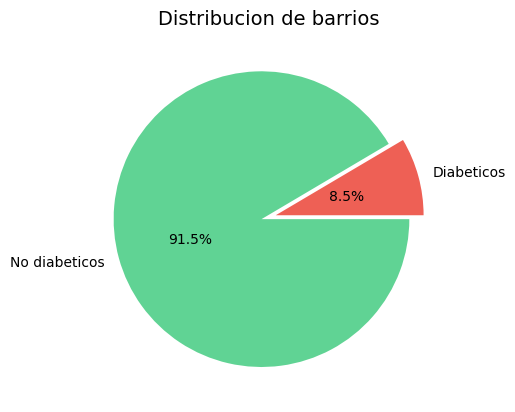

In [ ]:
medidas=[numero_de_diabeticos,numero_de_no_diabeticos]
labels =['Diabeticos','No diabeticos']
colores = ["#EE6055","#60D394"]
#plt.pie(medidas, labels=nombres, autopct="%0.1f %%", colors=colores)

plt.pie(medidas, labels=labels, autopct="%.1f%%",explode=[0.05]*2, pctdistance=0.5, colors=colores)
plt.title("Distribucion de barrios", fontsize=14)


In [ ]:
df_nodiabetes.pivot_table(values='blood_glucose_level', index='gender')

,blood_glucose_level
gender,
Female,132.811429
Male,132.908668
Other,139.444444


In [ ]:
df.pivot_table(values='blood_glucose_level', index='gender')
df_diabetes.pivot_table(values='blood_glucose_level', index='gender')

,blood_glucose_level
gender,
Female,193.942838
Male,194.262441


In [ ]:
df_diabetes.pivot_table(values='age', index='smoking_history', columns=['gender','blood_glucose_level'])

gender                  Female                                              \
blood_glucose_level        126        130        140        145        155   
smoking_history                                                              
No Info              55.800000  58.661017  56.363636  59.036364  62.780000   
current              54.428571  54.857143  53.272727  56.729167  53.285714   
ever                 59.176471  57.105263  59.866667  54.727273  63.083333   
former               62.537037  62.395833  64.446809  65.843137  62.363636   
never                59.610465  61.697143  62.268657  63.164384  61.591837   
not current          57.250000  61.310345  58.156250  58.878788  60.333333   

gender                                                                      \
blood_glucose_level        159        160        200        220        240   
smoking_history                                                              
No Info              60.866667  61.941176  60.379310  66.982143  60.178082   
current              58.903226  54.121951  54.357143  50.666667  53.882353   
ever                 60.631579  57.000000  55.600000  54.000000  60.000000   
former               62.098361  64.245614  68.520000  63.867925  63.558140   
never                61.645833  63.881657  61.948529  64.600000  62.487500   
not current          59.384615  58.585366  56.708333  59.880000  66.500000   

gender               ...       Male                                   \
blood_glucose_level  ...        145        155        159        160   
smoking_history      ...                                               
No Info              ...  58.372093  59.622642  62.296875  60.454545   
current              ...  54.157895  55.966667  54.880952  54.605263   
ever                 ...  61.388889  63.190476  56.300000  57.700000   
former               ...  66.739130  66.708333  63.016667  68.617284   
never                ...  59.318966  59.830189  57.548673  60.412281   
not current          ...  60.739130  61.472222  57.812500  63.047619   

gender                                                                      \
blood_glucose_level        200        220        240        260        280   
smoking_history                                                              
No Info              57.910714  57.152174  64.733333  59.346154  59.476190   
current              57.804878  59.128205  54.628571  59.175000  55.380000   
ever                 62.321429  62.823529  62.625000  64.928571  62.400000   
former               65.681159  66.890411  66.357143  64.114754  65.280488   
never                61.308333  56.159091  59.990000  59.241758  58.477477   
not current          62.545455  66.173913  64.368421  63.633333  58.807692   

gender                          
blood_glucose_level        300  
smoking_history                 
No Info              63.014493  
current              54.020833  
ever                 62.000000  
former               66.355263  
never                59.677419  
not current          62.173913  

[6 rows x 26 columns]

#Análisis categórico
Empezamos analizando las variables categóricas para los diabeticos, separamos las muestras de pacientes que sufren diabetes y que no y revisamos las variables que más afectan.


*   Género
*   Historial como fumador
*   Hipertensión
*   Enfermedades Cardiovasculares


Relación de diabeticos masculinos y femeninos. No vemos especial relación en ser diabético y el género.

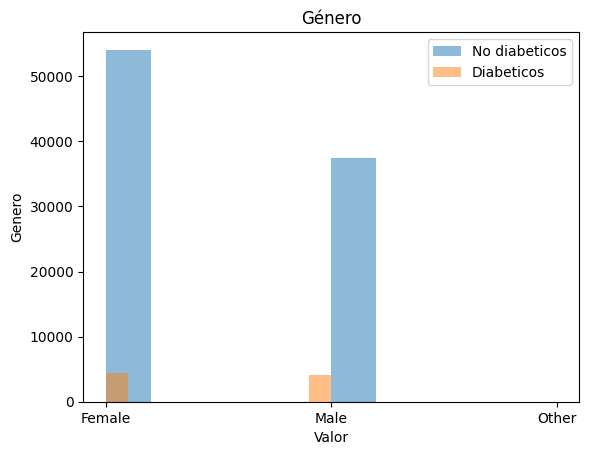

In [ ]:
plt.hist(df_nodiabetes['gender'], bins=10, alpha=0.5, label='No diabeticos')  # alpha controla la transparencia
plt.hist(df_diabetes['gender'], bins=10, alpha=0.5, label='Diabeticos')

# Configuración de la leyenda y etiquetas
plt.legend(loc='upper right')
plt.xlabel('Valor')
plt.ylabel('Genero')
plt.title('Género')

# Mostrar el gráfico
plt.show()

Relación entre el consumo de tabaco y la enfermedad. De la misma forma, no hay relación entre el consumo de tabaco y la diabetes.

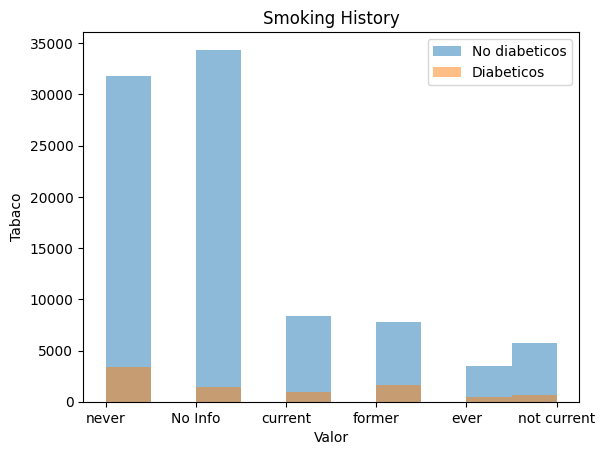

In [ ]:

plt.hist(df_nodiabetes['smoking_history'], bins=10, alpha=0.5, label='No diabeticos')  # alpha controla la transparencia
plt.hist(df_diabetes['smoking_history'], bins=10, alpha=0.5, label='Diabeticos')

# Configuración de la leyenda y etiquetas
plt.legend(loc='upper right')
plt.xlabel('Valor')
plt.ylabel('Tabaco')
plt.title('Smoking History')

# Mostrar el gráfico
plt.show()

Relación entre el consumo de tabaco y la hipertensión, no hay mayor ponderancia de diabéticos que sufran hipertensión en relación a los pacientes que no resultaron con la enfermedad.

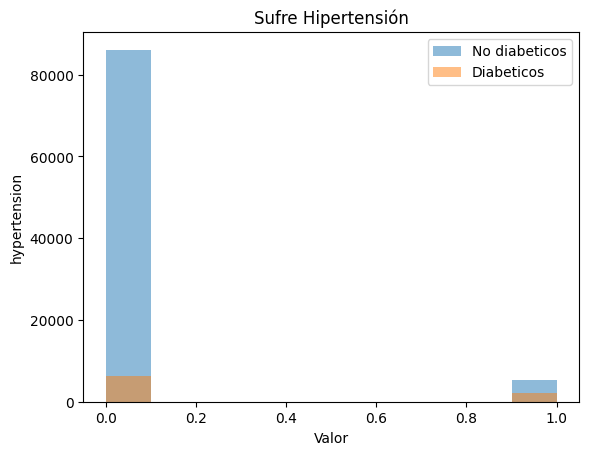

In [ ]:
plt.hist(df_nodiabetes['hypertension'], bins=10, alpha=0.5, label='No diabeticos')  # alpha controla la transparencia
plt.hist(df_diabetes['hypertension'], bins=10, alpha=0.5, label='Diabeticos')

# Configuración de la leyenda y etiquetas
plt.legend(loc='upper right')
plt.xlabel('Valor')
plt.ylabel('hypertension')
plt.title('Sufre Hipertensión')

# Mostrar el gráfico
plt.show()

Y finalmente, tampoco vemos relación entre sufrir cardiopatías y sufrir diabetes.

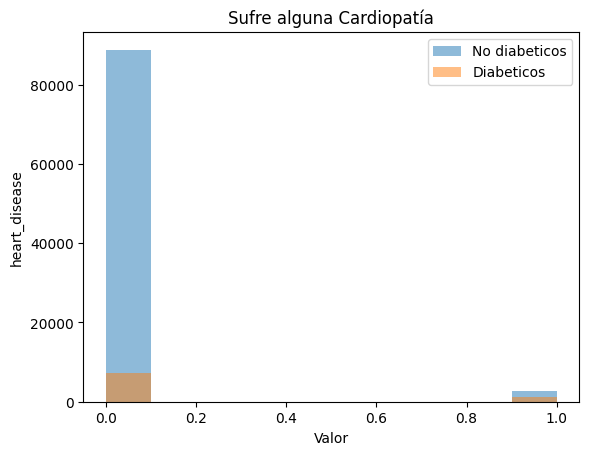

In [ ]:
plt.hist(df_nodiabetes['heart_disease'], bins=10, alpha=0.5, label='No diabeticos')  # alpha controla la transparencia
plt.hist(df_diabetes['heart_disease'], bins=10, alpha=0.5, label='Diabeticos')

# Configuración de la leyenda y etiquetas
plt.legend(loc='upper right')
plt.xlabel('Valor')
plt.ylabel('heart_disease')
plt.title('Sufre alguna Cardiopatía')

# Mostrar el gráfico
plt.show()

#Analisis numérico
A continuación vamos a analizar las variables numéricas y determinar si alguna nos afecta en la probabilidad de sufrir diabetes.


*   Edad
*   Bmi, índice de masa corporal
*   Niveles de HbA1C
*   Niveles de glucosa en sangre



Relación entre ser diabético y la edad. Mas edad, más probabilidad. Y esta relación no se ve afectada con el género, como se vió antes.

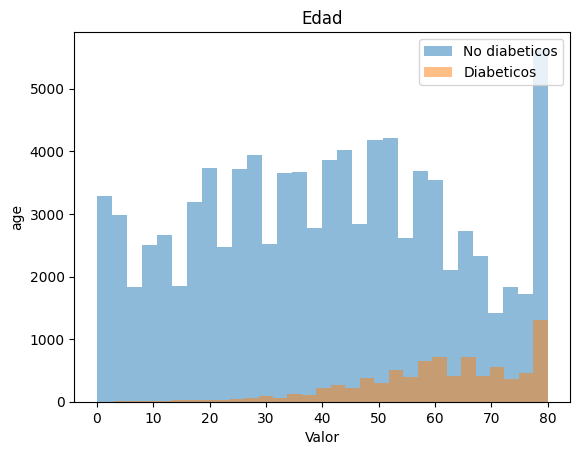

In [ ]:
plt.hist(df_nodiabetes['age'], bins=30, alpha=0.5, label='No diabeticos')  # alpha controla la transparencia
plt.hist(df_diabetes['age'], bins=30, alpha=0.5, label='Diabeticos')

# Configuración de la leyenda y etiquetas
plt.legend(loc='upper right')
plt.xlabel('Valor')
plt.ylabel('age')
plt.title('Edad')

# Mostrar el gráfico
plt.show()

<Axes: xlabel='age', ylabel='Count'>

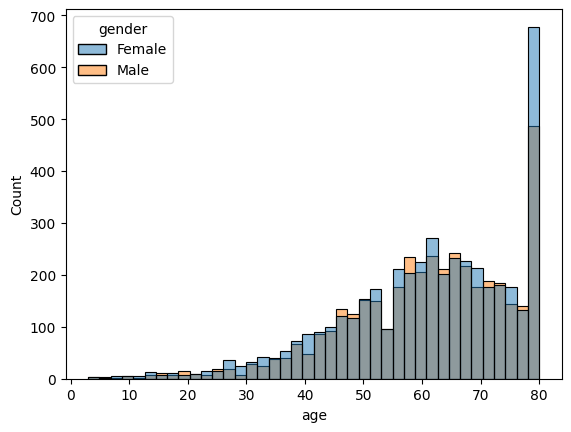

In [ ]:
sns.histplot(df_diabetes,x='age',hue='gender')

Relación entre ser diabético y el indice de masa corporal BMI. Podemos ver que a medida que aumenta la edad, y a mayor indice de masa corporal, la probabilidad de diabetes aumenta.

In [ ]:
px.scatter(df,x='age',y='bmi',color='diabetes')

In [ ]:
px.scatter(df,x='HbA1c_level',y='blood_glucose_level',color='diabetes')

Relacion entre ser diabetico y los niveles de HbA1c. En este caso podemos ver que a partir de 6,5 hacia arriba, los valores indican directamente una relación con la diabetes.

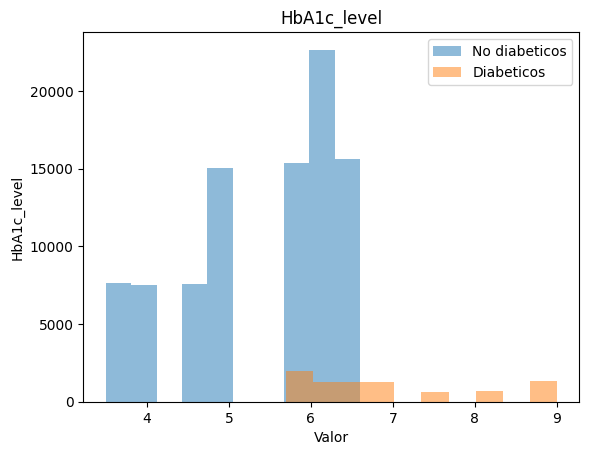

In [ ]:
plt.hist(df_nodiabetes['HbA1c_level'], bins=10, alpha=0.5, label='No diabeticos')  # alpha controla la transparencia
plt.hist(df_diabetes['HbA1c_level'], bins=10, alpha=0.5, label='Diabeticos')

# Configuración de la leyenda y etiquetas
plt.legend(loc='upper right')
plt.xlabel('Valor')
plt.ylabel('HbA1c_level')
plt.title('HbA1c_level')

# Mostrar el gráfico
plt.show()

Relacion entre el ser diabetico y el nivel de glucosa en sangre. Vemos que, siendo 150 niveles normales y habituales en los dos grupos, a mayores valores de glucosa en sangre le corresponden directamente casos de diabetes, mientras que no existen casos en los valores más bajos. Por lo tanto hay una relación directa entre ser diabético y el nivel de glucosa en sangre.

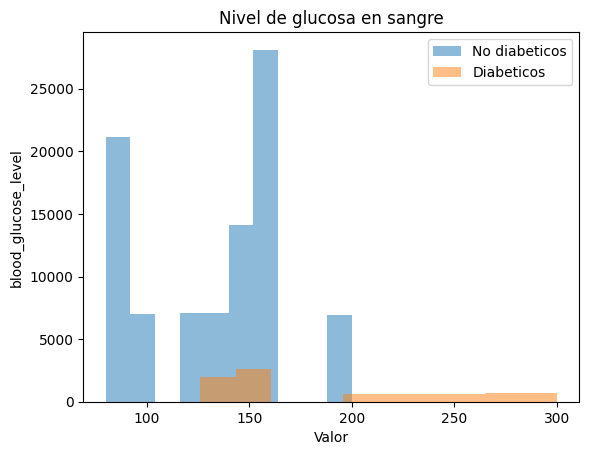

In [ ]:
plt.hist(df_nodiabetes['blood_glucose_level'], bins=10, alpha=0.5, label='No diabeticos')  # alpha controla la transparencia
plt.hist(df_diabetes['blood_glucose_level'], bins=10, alpha=0.5, label='Diabeticos')

# Configuración de la leyenda y etiquetas
plt.legend(loc='upper right')
plt.xlabel('Valor')
plt.ylabel('blood_glucose_level')
plt.title('Nivel de glucosa en sangre')

# Mostrar el gráfico
plt.show()

#Conclusiones:
No hay relación directa de la diabetes con variables categóricas como el género, ser fumador, antecedentes de problemas cardiovasculares o hipertensión.
Vemos relación de la edad con la diabétes, a más edad mayor probabilidad de diabetes. Pero sobre todo, se vió una relación entre la edad y el índice corporal.
La mayor correlación entre la diabetes y las variables numericas está en HbA1c_level y blood glucose leve.

# Algoritmo Machine Learning
Vamos a seleccionar qué algoritmo funciona mejor para la previsión de que un paciente sea diabético según ciertos parámetros. Regresión logistica o KNN.

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80,0,1,never,25.19,6.6,140,0
1,Female,54,0,0,No Info,27.32,6.6,80,0
2,Male,28,0,0,never,27.32,5.7,158,0
3,Female,36,0,0,current,23.45,5.0,155,0
4,Male,76,1,1,current,20.14,4.8,155,0


Vemos la correlación entre variables numéricas y confirmamos que las mejores variables que se relacionan con la diabetes son el nivel HbA1c_level y el nivel de glucosa en sangre.

In [ ]:
X=df[[ 'HbA1c_level','blood_glucose_level']]
y=df['diabetes']

In [ ]:
X

,HbA1c_level,blood_glucose_level
0,6.6,140
1,6.6,80
2,5.7,158
3,5.0,155
4,4.8,155
...,...,...
99995,6.2,90
99996,6.5,100
99997,5.7,155
99998,4.0,100


**Regresion Logistica**

In [ ]:
# Importar biblioteca
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score

In [ ]:
X=df[[ 'HbA1c_level','blood_glucose_level']]
y=df['diabetes']

# Dividir el conjunto de datos en conjuntos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logisticmodel=LogisticRegression(random_state=42, max_iter=500,\
                                 solver='newton-cg').fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning:

Rounding errors prevent the line search from converging

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning:

Line Search failed



In [ ]:
y_test=logisticmodel.predict(X_test)

In [ ]:
X=df[[ 'HbA1c_level','blood_glucose_level']]
y=df['diabetes']

# Dividir el conjunto de datos en conjuntos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Inicializar el modelo de regresión logística
model = LogisticRegression()

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = np.mean(predictions == y_test)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")



Precisión del modelo: 95.09%


**KNN**

vamos a probar con el modelo KNN.

In [ ]:
# Importar las bibliotecas necesarias
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler



In [ ]:
X=df[[ 'HbA1c_level','blood_glucose_level']]
y=df['diabetes']

# Dividir el conjunto de datos en conjuntos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Inicializar el clasificador KNN con un valor de k (número de vecinos) deseado
n_neighbors=5 # Puedes ajustar el valor de k según tu necesidad
knn = KNeighborsClassifier(n_neighbors)

# Entrenar el modelo con el conjunto de entrenamiento
knn.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = knn.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

print('Precision del K-NN en entrenamiento: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Precision del  K-NN en testing: {:.2f}'
     .format(knn.score(X_test, y_test)))

Precisión del modelo: 97.08%
Precision del K-NN en entrenamiento: 0.97
Precision del  K-NN en testing: 0.97


Confirmemos la precisión viendo la Confusión Matrix y el Reporte sobre el conjunto de test, que nos detalla los aciertos y fallos:

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[18222     0]
 [  583  1192]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18222
           1       1.00      0.67      0.80      1775

    accuracy                           0.97     19997
   macro avg       0.98      0.84      0.89     19997
weighted avg       0.97      0.97      0.97     19997



En nuestra matriz podemos ver que el valor de f1 para el valor con diabetes es de 0.80, un valor bastante bueno.

La precision de nuestro modelo es excelente.

KNN da mejores valores en su modelo

Vamos a revisar la grafica con los resultados de los valores, apoyandonos que tenemos dos opciones posibles y podemos observarlo en 2 dimensiones.

In [ ]:
X

,HbA1c_level,blood_glucose_level
0,6.6,140
1,6.6,80
2,5.7,158
3,5.0,155
4,4.8,155
...,...,...
99995,6.2,90
99996,6.5,100
99997,5.7,155
99998,4.0,100


In [ ]:
#from matplotlib.colors import ListedColormap
##import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

#h = .02  # step size in the mesh

# Create color maps
#cmap_light = ListedColormap(['#FFAAAA', '#ffcc99', '#ffffb3','#b3ffff','#c2f0c2'])
#cmap_bold = ListedColormap(['#FF0000', '#ff9933','#FFFF00','#00ffff','#00FF00'])
# we create an instance of Neighbours Classifier and fit the data.
#clf = KNeighborsClassifier(n_neighbors, weights='distance')
#clf.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
#x_min, x_max = X['HbA1c_level'].min() - 1, X['HbA1c_level'].max() + 1
#y_min, y_max = X['blood_glucose_level'].min() - 1, X['blood_glucose_level'].max() + 1
#xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                         np.arange(y_min, y_max, h))
#Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
#Z = Z.reshape(xx.shape)
#plt.figure()
#plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
#plt.scatter(X['HbA1c_level'], X['blood_glucose_level'], c=y, cmap=cmap_bold,
#                edgecolor='k', s=20)
#plt.xlim(xx.min(), xx.max())
#plt.ylim(yy.min(), yy.max())

#patch0 = mpatches.Patch(color='#FF0000', label='1')
#patch1 = mpatches.Patch(color='#ff9933', label='2')
#patch2 = mpatches.Patch(color='#FFFF00', label='3')
#patch3 = mpatches.Patch(color='#00ffff', label='4')
#patch4 = mpatches.Patch(color='#00FF00', label='5')
#plt.legend(handles=[patch0, patch1, patch2, patch3,patch4])


#plt.title("7-Class classification (k = %i, weights = '%s')"% (n_neighbors, weights))

#plt.show()

#Entrenamiento y mejora del algoritmo

Elegimos el mejor valor de k

([<matplotlib.axis.XTick at 0x7b01b5d01930>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20')])

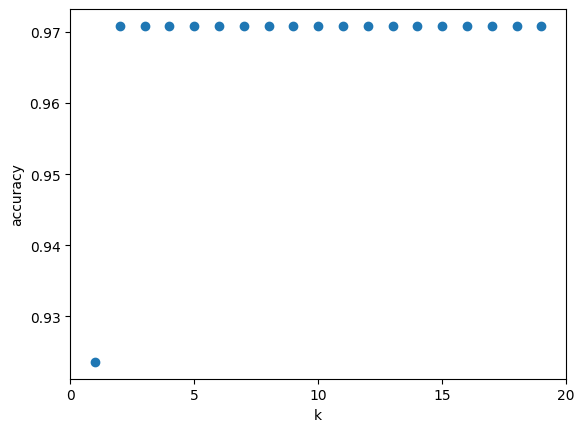

In [ ]:
k_range = range(1,20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

De esta grafica podemos interpretar que a partir del valor K=3 la precision es la misma, y perfecta.

Vamos a usar el algoritmo con nuevos pacientes y valores

In [ ]:
#print(clf.predict([[5, 1.0]]))

#PCA- Principal Component Analysis

Chequeamos las variables independientes que mejor funcionan en nuestro modelo mediante la técnica de PCA.

Scaleamos los datos para más adelante comparar las variables

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80,0,1,never,25.19,6.6,140,0
1,Female,54,0,0,No Info,27.32,6.6,80,0
2,Male,28,0,0,never,27.32,5.7,158,0
3,Female,36,0,0,current,23.45,5.0,155,0
4,Male,76,1,1,current,20.14,4.8,155,0


eliminamos las variables que ya usamos en nuestro modelo (blood_glucose_level y HbA1c_level y convertimos nuestras variables categoricas en numericas.

In [ ]:
df2=df.drop('HbA1c_level',axis=1)
df2=df2.drop('blood_glucose_level',axis=1)
df2=pd.get_dummies(df2)
df2.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Female,gender_Male,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80,0,1,25.19,0,1,0,0,0,0,0,1,0
1,54,0,0,27.32,0,1,0,1,0,0,0,0,0
2,28,0,0,27.32,0,0,1,0,0,0,0,1,0
3,36,0,0,23.45,0,1,0,0,1,0,0,0,0
4,76,1,1,20.14,0,0,1,0,1,0,0,0,0


In [ ]:
#cargamos librerias PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [ ]:
std = StandardScaler()
X_std=std.fit_transform(df2)
df_std = pd.DataFrame(X_std,columns=df2.columns)
df_std.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Female,gender_Male,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,1.692565,-0.284467,4.935916,-0.321051,-0.304819,0.841175,-0.841175,-0.747015,-0.319978,-0.204223,-0.32123,1.359831,-0.262364
1,0.537897,-0.284467,-0.202597,-0.000114,-0.304819,0.841175,-0.841175,1.338661,-0.319978,-0.204223,-0.32123,-0.735386,-0.262364
2,-0.616771,-0.284467,-0.202597,-0.000114,-0.304819,-1.188813,1.188813,-0.747015,-0.319978,-0.204223,-0.32123,1.359831,-0.262364
3,-0.261488,-0.284467,-0.202597,-0.583225,-0.304819,0.841175,-0.841175,-0.747015,3.125214,-0.204223,-0.32123,-0.735386,-0.262364
4,1.514924,3.515345,4.935916,-1.081957,-0.304819,-1.188813,1.188813,-0.747015,3.125214,-0.204223,-0.32123,-0.735386,-0.262364


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca_df = PCA()
x_transformado=pca_df.fit_transform(df_std)
x_transformado

array([[ 2.37006954e+00, -3.14434542e-01,  7.66612503e-02, ...,
        -5.23651452e-02, -2.67268999e-14, -2.25546156e-15],
       [-5.85896528e-01, -1.12664994e+00,  1.21755973e+00, ...,
        -6.88769173e-01, -1.38175917e-15,  4.06618279e-15],
       [-3.72486703e-01,  1.04192246e+00, -2.17757807e+00, ...,
         3.16848053e-01, -3.26734755e-15, -3.28550878e-16],
       ...,
       [ 6.42600191e-01,  2.16619685e+00,  6.17365298e-01, ...,
        -4.77535716e-01,  1.28805254e-16, -1.14944905e-16],
       [ 7.49507254e-01, -1.50019192e+00, -1.30488125e+00, ...,
         1.11872028e+00, -2.65640162e-16, -2.62233481e-18],
       [ 3.43523543e-01, -9.32050734e-01,  6.66882558e-01, ...,
        -9.77420673e-01,  1.86876770e-16,  2.12343304e-17]])

In [ ]:
df_nuevo=pd.DataFrame(x_transformado,columns=['pc'+str(x) for x in range(1,14)])

In [ ]:
df_nuevo

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13
0,2.370070,-0.314435,0.076661,-1.359803,-0.199829,0.578470,0.992099,-4.389069,1.075819,1.513103,-0.052365,-2.672690e-14,-2.255462e-15
1,-0.585897,-1.126650,1.217560,-0.510392,-0.173636,0.025399,0.297181,0.366726,0.384102,0.580678,-0.688769,-1.381759e-15,4.066183e-15
2,-0.372487,1.041922,-2.177578,-0.148784,0.096664,-0.078018,-0.176391,-0.042336,0.089795,0.001259,0.316848,-3.267348e-15,-3.285509e-16
3,-0.035951,-1.044101,0.525656,2.845109,-1.669364,-0.299899,0.137699,-0.731211,-0.297109,-0.333137,-0.161482,-8.732732e-15,-5.063495e-16
4,2.043454,3.234341,1.397419,1.149699,-2.128051,0.570845,2.443648,-4.069234,-2.495092,1.605474,0.294433,1.376099e-15,1.141815e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99977,-0.042611,-0.971067,1.400512,-0.568285,-0.136947,0.022351,0.302486,0.371748,0.474934,0.912823,-1.614561,1.646789e-17,3.850056e-18
99978,-2.251255,-1.570604,0.787828,-0.494860,-0.222724,0.028664,0.255040,-0.409486,-0.465689,-0.718826,0.497692,9.576320e-17,-4.481886e-17
99979,0.642600,2.166197,0.617365,-0.376952,0.072017,-1.565681,-2.616643,-0.009072,-0.191241,-0.008072,-0.477536,1.288053e-16,-1.149449e-16
99980,0.749507,-1.500192,-1.304881,-0.111211,-0.081241,-0.059838,-0.126351,0.396245,0.612292,0.369668,1.118720,-2.656402e-16,-2.622335e-18


In [ ]:
pca_df.explained_variance_ratio_

array([1.66209741e-01, 1.58801620e-01, 1.07142222e-01, 8.83865866e-02,
       8.30749828e-02, 8.08561997e-02, 7.83058693e-02, 6.93747452e-02,
       6.42926367e-02, 5.84245556e-02, 4.51308406e-02, 6.67158411e-33,
       8.59511486e-34])

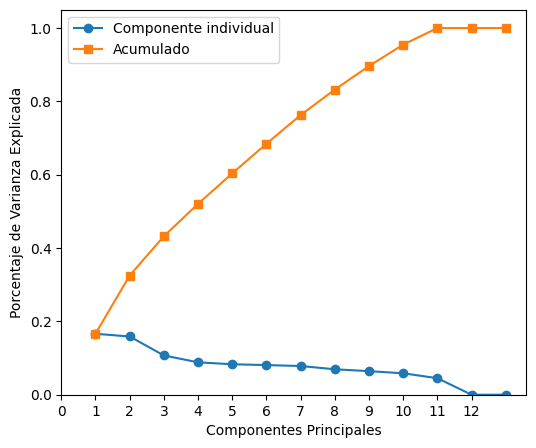

In [ ]:
plt.figure(figsize=(6,5))

plt.plot(range(1,14), pca_df.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(range(1,14), np.cumsum(pca_df.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(0,1.05); plt.xticks(range(13))
plt.legend(loc=0);

Esta grafica nos representa que no tengo ninguna otra variable que me aporte nada más que las dos variables que usamos en nuestro modelo KNN.